In [13]:
import pickle
from theano import shared
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
from sklearn.metrics import mean_squared_error
import seaborn
import xarray as xr
import os
import pathlib
import netCDF4 as nc
from IPython.core.display import HTML, display

In [2]:
pm.__version__

'3.2'

In [3]:
%matplotlib inline

In [4]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def GetPPC(data, trace, pmModel):
    """
    Runs post predictive checks (PPC).
    Returns 50% and 95% Highest Probability Density (HPD) intervals of predicted chlorophyll.
    Inputs:
        data: log of band ratio, pandas Series object
        trace: pymc3 trace object, result of mcmc sampling
        pmModel: pymc3 model object.
    Outputs:
        sig0: 50% HPD interval of predicted log chlorophyll
        sig1: 95% HPD interval of predicted log chlorophyll
    """
    
    ppc = pm.sample_ppc(trace, samples=1000, model=pmModel)
    # sample posterior predictive check for 50% and 95% density interval
    idx = np.argsort(data.values)
    sig50 = pm.hpd(ppc['chlPred'], alpha=0.5)[idx] 
    sig95 = pm.hpd(ppc['chlPred'], alpha=0.05)[idx]
    mean_pred = np.mean(ppc['chlPred'], axis=0)[idx]
    ppcDict = {'ci_50': sig50,
              'ci_95': sig95,
              'mean_pred': mean_pred }
    return ppcDict

def PlotPPC(data, chlObs, sig0, sig1, bayesCoeffs, oc4V6Coeffs=[], myOLSCoeffs=[],
           titleTail='on Training Set'):
    """
    Plots Posterior predictive checks, overlaid with 50% and 95% HPDs of predicted log chlorophyll
    Optionally adds result of OC4V6 estimation, and estimation from OLS computed in this notebook.
    Inputs:
        data: log of band ratio, pandas Series object
        chlObs: log of in situ observed chl, pandas Series object
        sig0: 50% HPD interval of predicted log chlorophyll
        sig1: 95% HPD interval of predicted log chlorophyll
        bayesCoeffs: point estimate of bayesian regression coefficients
        oc4v6Coeffs: historical OC4V6 coefficients
        myOLSCoeffs: frequentist OLS coefficients
    Outputs:
        axis handle to resulting plot.
    """
    chlBayes=0
    idx = np.argsort(data.values)
    ocxRatio_ord = data.values[idx]
    ocxRatioMock = np.linspace(data.min(),data.max(),100)
    for i,coeff in enumerate(bayesCoeffs):
        chlBayes += coeff*ocxRatioMock**i
    pl.figure(figsize=(16,10))
    pl.fill_between(ocxRatio_ord, sig0[:,0], sig0[:,1], color='k', alpha=1, label='50% HPD.')
    pl.fill_between(ocxRatio_ord, sig1[:,0], sig1[:,1], color='darkgray', alpha=0.5, label='95% HDP')
    pl.plot(data,chlObs, 'ko', alpha=0.5, markeredgecolor='k',  label='Observation')
    if oc4V6Coeffs:
        oc4V6Modl=0
        for i, coef in enumerate(oc4V6Coeffs):
            oc4V6Modl += coef * ocxRatioMock**i
        pl.plot(ocxRatioMock,oc4V6Modl,'r', linewidth=3, linestyle='--', label='OC4v6')
    if myOLSCoeffs:
        myChlModl=0
        for i,coeff in enumerate(myOLSCoeffs[::-1]):
            myChlModl+= coeff * ocxRatioMock**i
        pl.plot(ocxRatioMock,myChlModl,'m', linewidth=5, label='OLS')
    pl.plot(ocxRatioMock,chlBayes,'b', linewidth=2, label='Bayesian OC4')
    pl.xlabel(r'$log_{10}\frac{max(Rrs\left(\lambda_{blue}\right))}{Rrs\left(\lambda_{green}\right)}$', fontsize=20)
    pl.ylabel(r'$log_{10}\left(chlor_a\right)$', fontsize=20);
    pl.legend(fontsize=14);
    pl.title('Posterior Predictive Check %s' % titleTail);
    return pl.gca()

def PreProcessDataSet(ncpath):
    ncpath = str(ncpath)
    with xr.open_dataset(str(ncpath)) as ds:
        dssmall = ds[['Rrs_443', 'Rrs_490', 'Rrs_510', 'Rrs_555', 'chlor_a']]
        df = dssmall.to_dataframe()
    df.dropna(inplace=True)
    #df.reset_index(inplace=True, drop=False)
    return df

def Prep4Modeling(df):
    df['maxBlue'] = df.loc[:, ['Rrs_443','Rrs_490','Rrs_510']].max(axis=1)
    df['blue2green'] = df.maxBlue / df.Rrs_555
    dfLog = pd.DataFrame(columns=['mxBl2Gr', 'chl',])
    dfLog['mxBl2Gr'] = np.log10(df.blue2green.values)
    dfLog['chl'] = np.log10(df.chlor_a.values)
    return dfLog

Load the model and trace

In [63]:
with open('../pickleJar/basic_model.pkl', 'rb') as f:
    pkldict = pickle.load(f)
    trace, model, sharedVar = pkldict['trace'], pkldict['model'], pkldict['sharedVar']
    del pkldict

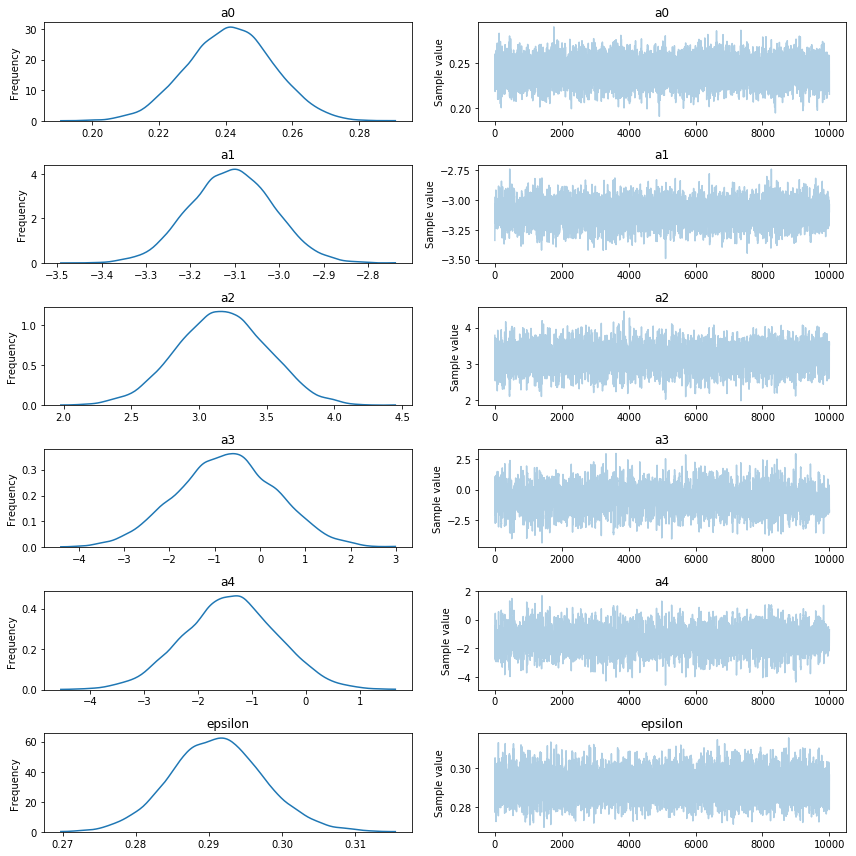

In [9]:
pm.traceplot(trace);

Load the "new data"

In [10]:
home = pathlib.Path.home()

Trying this with a brand new L3m file

In [11]:
ncpath = home / 'disk02/UNCERTAINTIES/Monte-Carlo/SWF/DATA/L2_L3/GLOBAL/StandardRun''/S20031932003196.L3m.nc'

In [14]:
df = PreProcessDataSet(ncpath)
df.head()

Rrs_443   Rrs_490   Rrs_510   Rrs_555   chlor_a
lat       lon                                                         
81.166672 -64.890015  0.004676  0.003944  0.003324  0.002208  0.390392
          -64.806664  0.004676  0.003944  0.003324  0.002208  0.390392
          -64.723312  0.004676  0.003944  0.003324  0.002208  0.390392
          -64.639961  0.004676  0.003944  0.003324  0.002208  0.390392
          -64.556602  0.004676  0.003944  0.003324  0.002208  0.390392

In [15]:
dfLog = Prep4Modeling(df)

In [16]:
sharedVar.set_value(dfLog.mxBl2Gr)

In [ ]:
# Two ways to evaluate the posterior:
# Get Posterior of all parameters, use the current data to get uncertainties on the model
# output
# Do posterior predictive check


In [80]:
#x_actual = dfLog.mxBl2Gr.values.reshape(1,-1)
x = np.linspace(-.3, 1, 100)
post_chl = 0
for i in range(5):
    a = trace.get_values('a%d' %i, thin=1)[:,None]
    post_chl +=  a * x ** i

In [67]:
x_actual.shape

(1, 1301619)

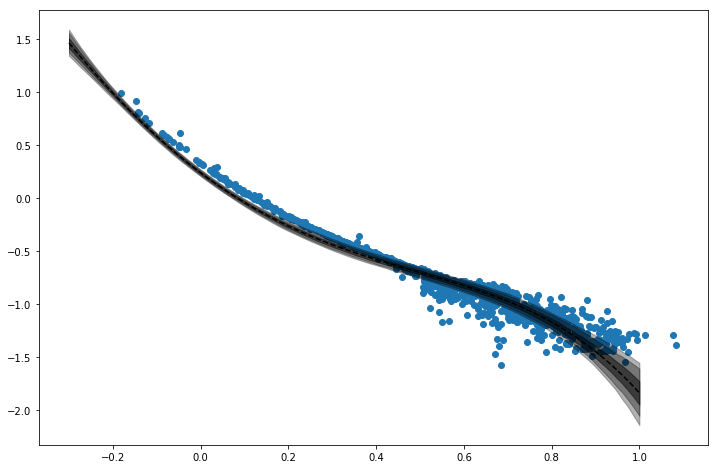

In [94]:
sample_idx = np.random.choice(np.arange(x_actual.size), 
                              size=1000, replace=False)
x_smpl = x_actual.ravel()[sample_idx]
y_smpl = dfLog.chl.values[sample_idx]
f, ax = pl.subplots(figsize=(12, 8))
ax.scatter(x_smpl, y_smpl)
ax.plot(x, np.median(post_chl, axis=0), 'k--')
for ci in [0.67, 0.95, 0.99]:
    alpha = 1-ci
    hpd = pm.hpd(post_chl, alpha=alpha)
    ax.fill_between(x, y1=hpd[:, 0], y2=hpd[:, 1], alpha=alpha*0.6+0.3, color='k')
#ax.set_yscale('log')
#ax.set_xlim((x_smpl.min()*2, x_smpl.max()))
#ax.set_ylim((y_smpl.min(), y_smpl.max()*2))

In [182]:
sharedVar.set_value(dfLog.mxBl2Gr)
sig_dict = GetPPC(dfLog.mxBl2Gr,
                    trace=trace,
                    pmModel=model)

100%|██████████| 1000/1000 [00:54<00:00, 18.38it/s]


In [173]:
sig_dict.keys()

dict_keys(['ci_50', 'ci_95', 'mean_pred'])

In [174]:
idx = np.argsort(dfLog.mxBl2Gr)
percent_error_95 = np.abs(1 - sig_dict['ci_95'] 
                          / dfLog.chl[idx].values.reshape(-1,1)) * 100

In [175]:
binmin = np.floor(np.log10(percent_error).min())
binmax = np.ceil(np.log10(percent_error).max())

In [176]:
binmin, binmax

(-4.0, 7.0)

In [178]:
num_bins = 100
bins = np.logspace(binmin, binmax, num_bins)

<IPython.core.display.Javascript object>


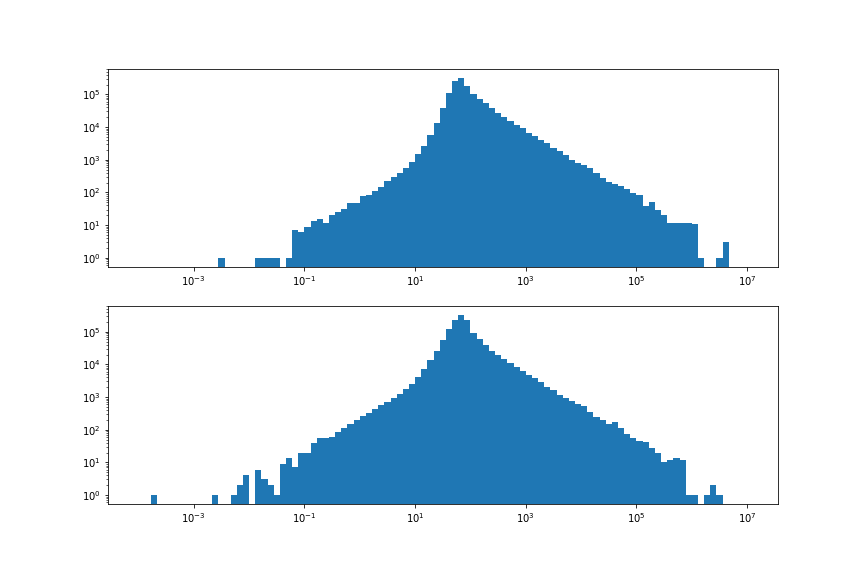

In [146]:
%matplotlib notebook
_, ax = pl.subplots(nrows=2, figsize=(12, 8))
ax[0].hist(percent_error[:, 0], bins=bins, log=True);
ax[0].set_xscale('log')
ax[1].hist(percent_error[:, 1], bins=bins, log=True);
ax[1].set_xscale('log')
#pl.xlim((10, 1000))
pl.show()

In [190]:
idx.size

1301619

In [195]:
sig_dict['mean_pred'].shape

(1301619,)

In [ ]:
ppc = pm.sample_ppc(trac)

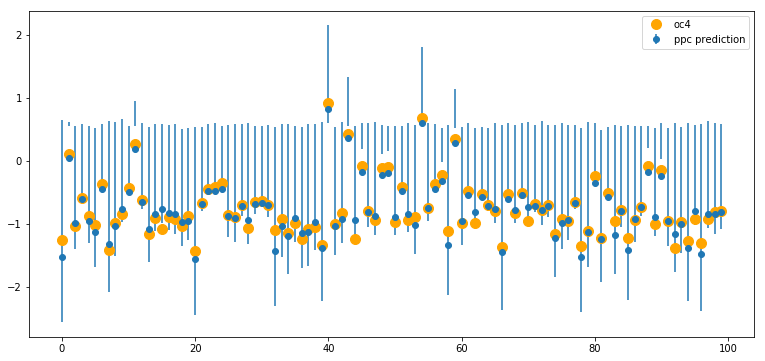

In [196]:
%matplotlib inline
sample_size=100
samples = np.random.choice(np.arange(idx.size), size=sample_size, replace=False)
_, ax = pl.subplots(figsize=(13, 6))
#pl.plot(dfLog.chl[idx[:10]], ls='', marker='.')`
ax.errorbar(np.arange(sample_size), sig_dict['mean_pred'][samples],
            yerr=sig_dict['ci_95'][samples].T, fmt='o', label='ppc prediction')
ax.plot(np.arange(sample_size), dfLog.chl[idx[samples]], ls='', marker='o',
        color='orange', label='oc4', markersize=10)
ax.legend(loc='best')

In [101]:
idx = np.argsort(dfLog.mxBl2Gr.values)
sig1[:10], dfLog.chl[idx[:10]]

(array([[ 1.28640096,  2.51145855],
        [ 1.3035812 ,  2.45806604],
        [ 1.22481232,  2.48022345],
        [ 1.17772019,  2.32569551],
        [ 1.17275905,  2.30803536],
        [ 1.15716132,  2.32641758],
        [ 1.16230536,  2.31602336],
        [ 1.13573011,  2.29879999],
        [ 1.14961848,  2.30748342],
        [ 1.13565613,  2.360445  ]]), 192376    1.887118
 93458     1.874164
 93457     1.874164
 406843    1.768151
 191361    1.762477
 191362    1.762477
 192690    1.823168
 192691    1.823168
 92679     1.737322
 92678     1.737322
 Name: chl, dtype: float64)

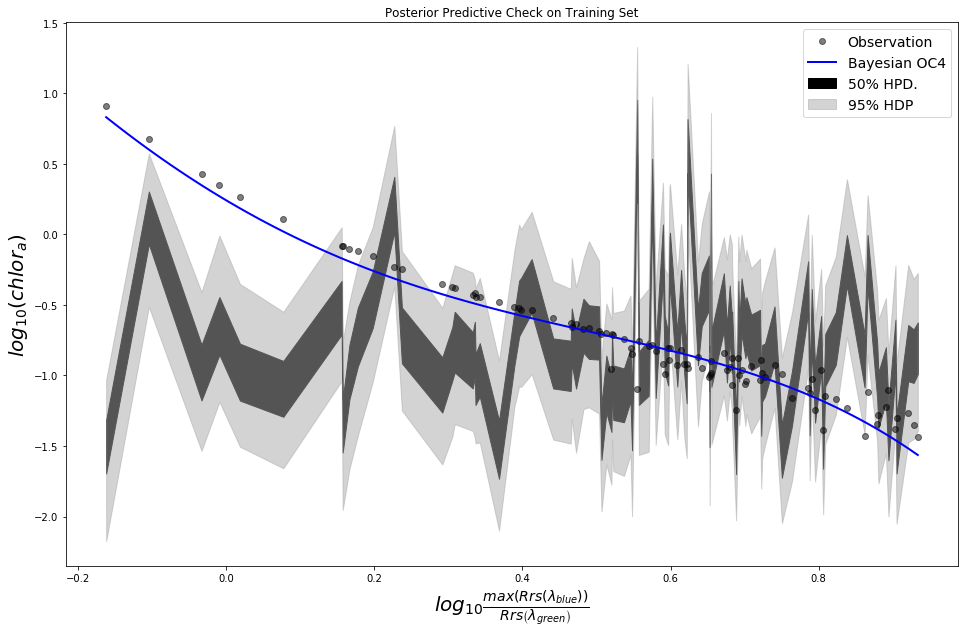

In [197]:
bayesCoeffs = [trace['a%d' %i].mean() for i in range(5)]
ax = PlotPPC(dfLog.mxBl2Gr[idx[samples]], dfLog.chl[idx[samples]],
             sig_dict['ci_50'][samples], sig_dict['ci_95'][samples], bayesCoeffs)

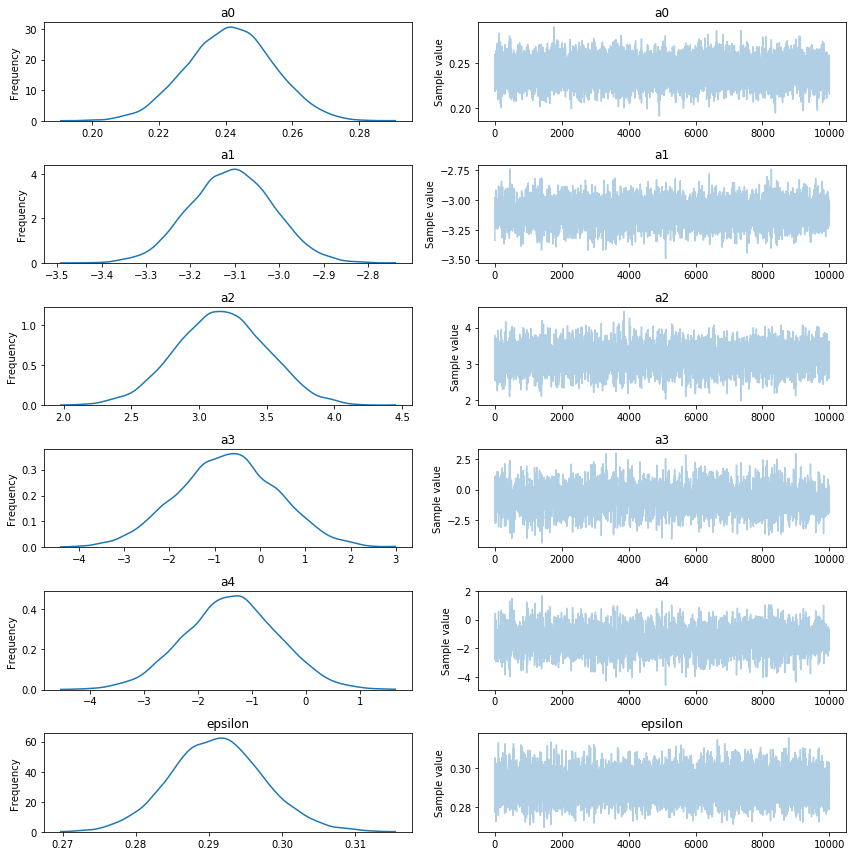

In [92]:
pm.traceplot(trace);